In [1]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt
from IPython import display
import matplotlib_inline

In [2]:

def use_svg_display():  #@save
    """使用svg格式在Jupyter中显示绘图"""
#     display.set_matplotlib_formats()
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [3]:
#生成数据
true_w = torch.tensor([2, -3.4])
true_b = 4.2

#features是x labels是y
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 0.7198, -1.2454]) 
label: tensor([9.8732])


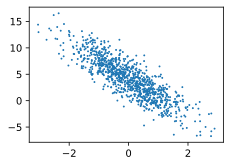

In [5]:
set_figsize()
plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

In [6]:
#打乱数据集并生成小批量,
#生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        


In [8]:
#初始化
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [9]:
#定义回归
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

#定义损失函数
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

#
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


In [10]:
#
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
batch_size=10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.048499
epoch 2, loss 0.000210
epoch 3, loss 0.000051


In [11]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0012, -0.0014], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)
